In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import time
from tqdm.auto import tqdm
from timeit import default_timer as timer
import numpy as np
import torch.optim as optim


## Device configuration and hyperparameters

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64 # Might change later
lr = 0.001

## Loading the CIFAR10 dataset (Augmented)
- This is readily available in pytorch in the dataset module.

In [4]:
# Data Preprocessing
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


################################# TRAINING AND TEST DATASETS ############################
# Loading the dataset

# Training dataset
cifar10_trainset = torchvision.datasets.CIFAR10(root='./data',
                                               train=True,
                                               download=True,
                                               transform=transform)
cifar10_trainloader = DataLoader(cifar10_trainset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 )

# Test dataset
cifar10_testset = torchvision.datasets.CIFAR10(root='./data',
                                               train=False,
                                               download=True,
                                               transform=transform
                                               )
cifar10_testloader = DataLoader(cifar10_testset,
                                batch_size=batch_size,
                                shuffle=False
                                )


# Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# Print dataset information
print(f"Training Data:")
print(f"- Total images: {len(cifar10_trainset)}")
print(f"- Batch size: {batch_size}")
print(f"- Batches per epoch: {len(cifar10_trainloader)}")

print(f"\nTest Data:")
print(f"- Total images: {len(cifar10_testset)}")
print(f"- Batches: {len(cifar10_testloader)}")

Training Data:
- Total images: 50000
- Batch size: 64
- Batches per epoch: 782

Test Data:
- Total images: 10000
- Batches: 157


## Creating Helper functions
It is often important for us to create a helper functions when training and testing our model. This helps modularize our code and make it somewhat more compact.

In [6]:
# Calculating the accuracy --> (True Positive / (True Positive + True Negative))*100
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc


# Difference in Time
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """ Prints difference between start and end time. """
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds!😮‍💨")
  return total_time

In [7]:
# Ploting function
def plot_results(results, seeds):
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    for i, result in enumerate(results):
        plt.plot(result["train_losses"], label=f'Seed {seeds[i]}')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Test Accuracy
    plt.subplot(1, 2, 2)
    for i, result in enumerate(results):
        plt.plot(result["test_accuracies"], label=f'Seed {seeds[i]}')
    plt.title('Test Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [16]:
def run_experiment(model_class, trainloader, testloader, seeds, device):
    results = []

    # Iterate through the provided seeds
    for seed in seeds:
        print(f"{50 * '-'}😤")
        print(f"\nTraining with seed: {seed}")

        torch.manual_seed(seed)

        # Create model once
        model = model_class().to(device)

        # Create optimizer with the model's parameters
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model with the current seed
        result = DCNN_train_model(
            model=model,
            trainloader=trainloader,
            testloader=testloader,
            seed=seed,
            device=device,
            criterion=nn.CrossEntropyLoss(),
            optimizer=optimizer,
            epochs=40
        )

        # Store the results
        results.append(result)

    # Extract the final training and testing accuracies
    train_accs = [r["final_train_acc"] for r in results]
    test_accs = [r["final_test_acc"] for r in results]
    total_training_time_lst = [r["training_time"] for r in results]

    # Calculate total training time
    total_training_time_in_seconds = np.sum(total_training_time_lst)
    minutes = int(total_training_time_in_seconds // 60)
    seconds = int(total_training_time_in_seconds % 60)

    # Report statistics
    print(f"\nMean train accuracy: {np.mean(train_accs):.4f} ± {np.std(train_accs):.4f}")
    print(f"Mean test accuracy: {np.mean(test_accs):.4f} ± {np.std(test_accs):.4f}")
    print(f"The total training time: {minutes} minutes and {seconds} seconds! Yayyyy 🤩😮‍💨")

    return results

## Model Design

In [17]:
# Initial architecture -- If it does not work maybe tune or use ready made architectures

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.num_classes = 10

        # Creating the convolutional layers using Sequential
        self.conv_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        # FC layers -- 32x32 → 16x16 → 8x8 → 4x4 (Spatial changes)
        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=256 * 4 * 4,
                      out_features=512), # I chose 512 as many established CNN architectures use 256, 512, 1024 as the empirical standard.
            nn.ReLU(),
            nn.Dropout(0.5), # This is the regularization technique I use to reduce overfitting
            nn.Linear(in_features=512,
                      out_features=self.num_classes)
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Xavier initialization for Conv2d layers
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Xavier initialization for Linear layers
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # Initialize BatchNorm layers
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    # Forward Pass
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layers
        x = self.fc_layers(x)
        return x

# Training the model
The following steps will be used to train the model
- Implement a function for training the model
- Run experiment
- Plot results
- Visualize results

In [18]:
# Implementing the training function
def DCNN_train_model(model, trainloader, testloader, seed, device, criterion, optimizer, epochs):
    # Set the seed for reproducibility and start the timer
    torch.manual_seed(seed)
    train_time_start_on_cpu = timer()

    # Model reinitialization
    # model = model().to(device)
    print(f"The model:\n {model}")

    # Containers
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    # Training loop
    for epoch in tqdm(range(epochs)):
        model.train()
        epoch_loss = 0
        epoch_acc = 0


        # Batch training
        for batch_X, batch_y in  trainloader:
            # We move the data to the device (gpu in this case)
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Forward Prop (Forward Pass)
            y_pred = model(batch_X)

            # Calculate the corresponding loss
            loss = criterion(y_pred, batch_y)

            # Zero gradients
            optimizer.zero_grad()

            # Backward Prop (Backward Pass)
            loss.backward()

            # Updating the parameters -- update weights and biases
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(y_pred.data, 1)
             # Accumulate loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += accuracy_fn(y_true=batch_y, y_pred=predicted)

        # Calculate mean loss and accuracy for the epoch
        avg_train_loss = epoch_loss / len(trainloader)
        avg_train_acc = epoch_acc / len(trainloader)

        # Testing
        model.eval()
        test_loss = 0
        test_acc = 0

        with torch.inference_mode():
            for test_X, test_y in testloader:
                # Move data to device
                test_X, test_y = test_X.to(device), test_y.to(device)

                # 1. Forward pass
                test_pred = model(test_X)

                # 2. Calculate loss
                batch_test_loss = criterion(test_pred, test_y)

                # Get predictions and calculate accuracy
                _, predicted = torch.max(test_pred.data, 1)

                # Accumulate test metrics
                test_loss += batch_test_loss.item()
                test_acc += accuracy_fn(y_true=test_y, y_pred=predicted)

            # Calculate mean test metrics
            avg_test_loss = test_loss / len(testloader)
            avg_test_acc = test_acc / len(testloader)

        # Store metrics
        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        test_losses.append(avg_test_loss)
        test_accuracies.append(avg_test_acc)

        # Print progress every 1 epoch
        if epoch % 1 == 0:
            print(f"\nEpoch: {epoch} | Train Loss: {avg_train_loss:.5f}, Train Acc: {avg_train_acc:.2f}% | Test Loss: {avg_test_loss:.5f}, Test Acc: {avg_test_acc:.2f}%")

    # Calculate total training time
    train_time_end_on_cpu = timer()
    total_train_time = print_train_time(
        start=train_time_start_on_cpu,
        end=train_time_end_on_cpu,
        device=device
    )

    return {
        "model": model,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
        "final_train_acc": avg_train_acc,
        "final_test_acc": avg_test_acc,
        "training_time": total_train_time
    }


Using device: cuda
--------------------------------------------------😤

Training with seed: 42
The model:
 CIFAR10_CNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()

  0%|          | 0/40 [00:00<?, ?it/s]


Epoch: 0 | Train Loss: 1.60341, Train Acc: 41.03% | Test Loss: 1.31525, Test Acc: 53.22%

Epoch: 1 | Train Loss: 1.21502, Train Acc: 56.79% | Test Loss: 1.11005, Test Acc: 60.51%

Epoch: 2 | Train Loss: 1.04155, Train Acc: 63.67% | Test Loss: 0.96551, Test Acc: 65.57%

Epoch: 3 | Train Loss: 0.92638, Train Acc: 68.18% | Test Loss: 0.74698, Test Acc: 74.25%

Epoch: 4 | Train Loss: 0.85145, Train Acc: 71.11% | Test Loss: 0.72480, Test Acc: 74.81%

Epoch: 5 | Train Loss: 0.78900, Train Acc: 73.15% | Test Loss: 0.68386, Test Acc: 76.78%

Epoch: 6 | Train Loss: 0.73672, Train Acc: 75.28% | Test Loss: 0.63889, Test Acc: 77.78%

Epoch: 7 | Train Loss: 0.68989, Train Acc: 77.01% | Test Loss: 0.62049, Test Acc: 78.76%

Epoch: 8 | Train Loss: 0.65213, Train Acc: 78.19% | Test Loss: 0.60570, Test Acc: 79.85%

Epoch: 9 | Train Loss: 0.61614, Train Acc: 79.43% | Test Loss: 0.54960, Test Acc: 81.53%

Epoch: 10 | Train Loss: 0.59085, Train Acc: 80.36% | Test Loss: 0.53792, Test Acc: 81.92%

Epoch: 1

  0%|          | 0/40 [00:00<?, ?it/s]


Epoch: 0 | Train Loss: 1.60193, Train Acc: 41.33% | Test Loss: 1.25268, Test Acc: 54.61%

Epoch: 1 | Train Loss: 1.22275, Train Acc: 56.04% | Test Loss: 1.12450, Test Acc: 59.25%

Epoch: 2 | Train Loss: 1.04905, Train Acc: 63.40% | Test Loss: 0.89239, Test Acc: 69.10%

Epoch: 3 | Train Loss: 0.93106, Train Acc: 67.80% | Test Loss: 0.81226, Test Acc: 71.28%

Epoch: 4 | Train Loss: 0.85365, Train Acc: 70.84% | Test Loss: 0.69680, Test Acc: 75.57%

Epoch: 5 | Train Loss: 0.78576, Train Acc: 73.26% | Test Loss: 0.66668, Test Acc: 77.27%

Epoch: 6 | Train Loss: 0.73444, Train Acc: 75.32% | Test Loss: 0.60444, Test Acc: 79.29%

Epoch: 7 | Train Loss: 0.69108, Train Acc: 76.90% | Test Loss: 0.58988, Test Acc: 79.80%

Epoch: 8 | Train Loss: 0.65362, Train Acc: 78.16% | Test Loss: 0.60212, Test Acc: 79.57%

Epoch: 9 | Train Loss: 0.61106, Train Acc: 79.64% | Test Loss: 0.58578, Test Acc: 80.90%

Epoch: 10 | Train Loss: 0.58562, Train Acc: 80.47% | Test Loss: 0.52514, Test Acc: 82.35%

Epoch: 1

  0%|          | 0/40 [00:00<?, ?it/s]


Epoch: 0 | Train Loss: 1.63140, Train Acc: 39.17% | Test Loss: 1.38244, Test Acc: 49.28%

Epoch: 1 | Train Loss: 1.23020, Train Acc: 55.83% | Test Loss: 1.02873, Test Acc: 62.72%

Epoch: 2 | Train Loss: 1.05105, Train Acc: 63.30% | Test Loss: 0.87186, Test Acc: 68.96%

Epoch: 3 | Train Loss: 0.93147, Train Acc: 68.08% | Test Loss: 0.85658, Test Acc: 70.62%

Epoch: 4 | Train Loss: 0.84593, Train Acc: 71.12% | Test Loss: 0.73177, Test Acc: 74.56%

Epoch: 5 | Train Loss: 0.78974, Train Acc: 73.33% | Test Loss: 0.68320, Test Acc: 76.74%

Epoch: 6 | Train Loss: 0.74283, Train Acc: 75.18% | Test Loss: 0.66597, Test Acc: 78.19%

Epoch: 7 | Train Loss: 0.69594, Train Acc: 76.87% | Test Loss: 0.59435, Test Acc: 80.08%

Epoch: 8 | Train Loss: 0.65515, Train Acc: 78.16% | Test Loss: 0.57107, Test Acc: 80.98%

Epoch: 9 | Train Loss: 0.62356, Train Acc: 79.31% | Test Loss: 0.58937, Test Acc: 80.60%

Epoch: 10 | Train Loss: 0.58920, Train Acc: 80.54% | Test Loss: 0.57375, Test Acc: 80.81%

Epoch: 1

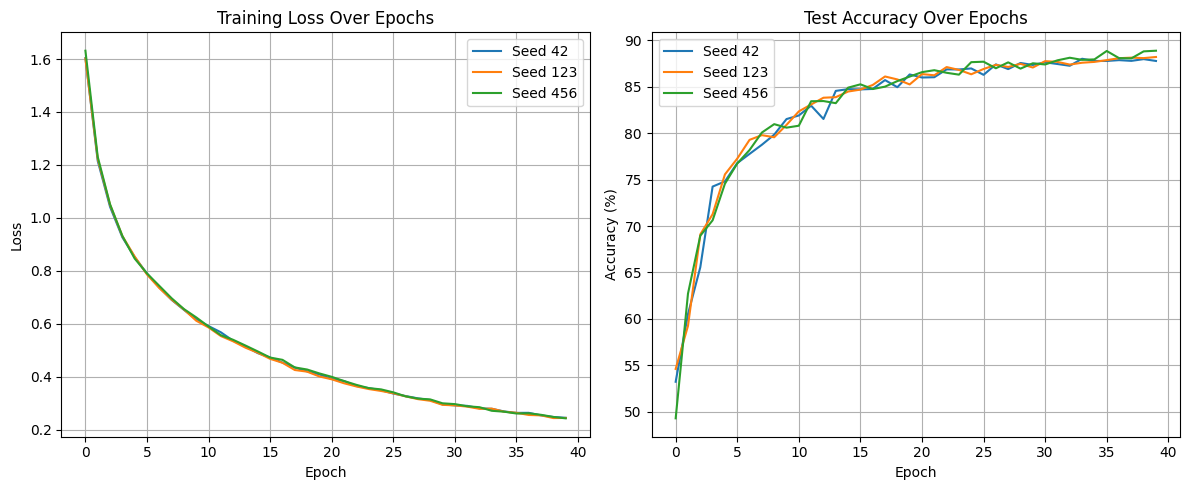

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

seeds = [42, 123, 456]

# Run experiment using our custom-made model.
results = run_experiment(
    model_class=CIFAR10_CNN,
    trainloader=cifar10_trainloader,
    testloader=cifar10_testloader,
    seeds=seeds,
    device=device
)

plot_results(results, seeds)